# Análise de Research Questions

## Detecção de Code Smells com Sistema Multi-Agentes baseado em LLM

**Modelo:** Claude Sonnet 4.5

**Abordagem:** Validação por contagem de code smells por módulo

### Research Questions:
- **RQ1:** Qual a eficácia do sistema multi-agentes na detecção de code smells?
- **RQ2:** Qual o impacto da qualidade dos prompts na performance da detecção?
- **RQ3:** Como o sistema multi-agentes se compara com análise estática tradicional (DPy)?
- **RQ4:** Qual a performance individual de cada agente especializado?
- **RQ5:** Qual o custo-benefício operacional do sistema multi-agentes?


In [40]:
import json
import warnings
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats

warnings.filterwarnings("ignore")

plt.rcParams["figure.figsize"] = (12, 6)
plt.rcParams["font.size"] = 11

BASE_DIR = Path().resolve().parent
RESULTS_DIR = BASE_DIR / "results"
GT_DIR = BASE_DIR / "dataset" / "ground_truth"
FIGURES_DIR = RESULTS_DIR / "figures"
FIGURES_DIR.mkdir(exist_ok=True)

# Preços Claude Sonnet 4.5
INPUT_PRICE_PER_M = 3.00
OUTPUT_PRICE_PER_M = 15.00

print(f"Diretório base: {BASE_DIR}")


Diretório base: /home/luis-chaves/Área de trabalho/tcc/multi-agent-smell-detector


## 1. Carregar Dados


In [41]:
# Ground Truth filtrado (DPy - apenas módulos do dataset)
gt = pd.read_csv(GT_DIR / "ground_truth_dpy_filtered.csv")

# Resultados do sistema
ma_complete = pd.read_csv(RESULTS_DIR / "csv" / "results_with_complete_prompts.csv")
ma_simple = pd.read_csv(RESULTS_DIR / "csv" / "results_simple_prompt.csv")

# Resultados do DPy (ferramenta de análise estática)
dpy = pd.read_csv(RESULTS_DIR / "dpy" / "dataset_implementation_smells.csv")

# Token usage
with open(RESULTS_DIR / "json" / "token_usage_complete_prompts.json") as f:
    tokens_complete = json.load(f)
with open(RESULTS_DIR / "json" / "token_usage_simple_prompt.json") as f:
    tokens_simple = json.load(f)

print("Ground Truth (DPy filtrado):")
print(f"  - Total de entradas: {len(gt)}")
print(f"  - Total de smells: {gt['Count'].sum()}")
print(f"\nMulti-agentes (Prompts Elaborados): {len(ma_complete)} detecções")
print(f"Multi-agentes (Prompts Simples): {len(ma_simple)} detecções")
print(f"DPy (Análise Estática): {len(dpy)} detecções")

print("\nDistribuicao no Ground Truth:")
gt_by_smell = gt.groupby("Smell")["Count"].sum().sort_values(ascending=False)
display(gt_by_smell.to_frame())


Ground Truth (DPy filtrado):
  - Total de entradas: 69
  - Total de smells: 411

Multi-agentes (Prompts Elaborados): 432 detecções
Multi-agentes (Prompts Simples): 563 detecções
DPy (Análise Estática): 385 detecções

Distribuicao no Ground Truth:


,Count
Smell,
Long Statement,205
Magic Number,90
Long Method,28
Empty Catch Block,26
Long Identifier,18
Long Lambda Function,16
Long Parameter List,14
Complex Method,6
Complex Conditional,5


## 2. Preparação dos Dados


In [42]:
# Mapeamento de arquivos para módulos
FILE_TO_MODULE = {
    "_codespell.py": "_codespell",
    "_spellchecker.py": "_spellchecker",
    "test_basic.py": "test_basic",
    "test_dictionary.py": "test_dictionary",
    "addr.py": "addr",
    "colorized.py": "colorized",
    "common.py": "common",
    "log.py": "log",
    "settings.py": "settings",
    "update.py": "update",
    "alienvault.py": "alienvault",
    "badips.py": "badips",
    "dataplane.py": "dataplane",
    "torproject.py": "torproject",
    "ff_ippo_store_experience.py": "ff_ippo_store_experience",
    "ff_ippo.py": "ff_ippo",
    "ff_mappo.py": "ff_mappo",
    "rec_ippo.py": "rec_ippo",
    "ff_isac.py": "ff_isac",
    "checkpointing.py": "checkpointing",
}

# Normalização de nomes de smells
SMELL_NORMALIZE = {
    "complex method": "Complex Method",
    "complex conditional": "Complex Conditional",
    "long method": "Long Method",
    "long parameter list": "Long Parameter List",
    "long statement": "Long Statement",
    "long identifier": "Long Identifier",
    "magic number": "Magic Number",
    "empty catch block": "Empty Catch Block",
    "missing default": "Missing Default",
    "long lambda function": "Long Lambda Function",
    "long message chain": "Long Message Chain",
}


def process_system_results(df):
    """Processa resultados do sistema para formato de contagem."""
    df = df.copy()
    df["Module"] = df["File"].apply(
        lambda x: FILE_TO_MODULE.get(x, x.replace(".py", "") if pd.notna(x) else "")
    )
    df["Smell_norm"] = df["Code_Smell"].str.lower().str.strip()
    df["Smell"] = df["Smell_norm"].apply(
        lambda x: SMELL_NORMALIZE.get(x, x.title()) if pd.notna(x) else ""
    )
    counts = df.groupby(["Module", "Smell"]).size().reset_index(name="Count")
    return counts


def process_dpy_results(df):
    """Processa resultados do DPy para formato de contagem."""
    df = df.copy()
    
    # Extrair nome do módulo do campo Module
    df["Module_clean"] = df["Module"].apply(
        lambda x: str(x).strip() if pd.notna(x) else ""
    )
    df["Smell_norm"] = df["Smell"].str.lower().str.strip()
    df["Smell_clean"] = df["Smell_norm"].apply(
        lambda x: SMELL_NORMALIZE.get(x, x.title()) if pd.notna(x) else ""
    )
    
    # Filtrar apenas módulos que estão no dataset
    df = df[df["Module_clean"].isin(FILE_TO_MODULE.values())]
    
    counts = (
        df.groupby(["Module_clean", "Smell_clean"]).size().reset_index(name="Count")
    )
    
    counts.columns = ["Module", "Smell", "Count"]
    
    return counts


sys_complete = process_system_results(ma_complete)
sys_simple = process_system_results(ma_simple)
sys_dpy = process_dpy_results(dpy)

print(f"Contagens (Elaborados): {sys_complete['Count'].sum()} detecções")
print(f"Contagens (Simples): {sys_simple['Count'].sum()} detecções")
print(f"Contagens (DPy): {sys_dpy['Count'].sum()} detecções")


Contagens (Elaborados): 432 detecções
Contagens (Simples): 563 detecções
Contagens (DPy): 385 detecções


## 3. Função de Validação por Contagem


In [43]:
def validate_by_count(gt_df, sys_df, label="Sistema"):
    """Valida sistema por contagem de smells por módulo."""

    all_modules = set(gt_df["Module"].unique()) | set(sys_df["Module"].unique())
    all_smells = set(gt_df["Smell"].unique()) | set(sys_df["Smell"].unique())

    gt_dict = {(r["Module"], r["Smell"]): r["Count"] for _, r in gt_df.iterrows()}
    sys_dict = {(r["Module"], r["Smell"]): r["Count"] for _, r in sys_df.iterrows()}

    results = []
    total_tp, total_fp, total_fn, total_tn = 0, 0, 0, 0

    for module in all_modules:
        for smell in all_smells:
            gt_count = gt_dict.get((module, smell), 0)
            sys_count = sys_dict.get((module, smell), 0)

            tp = min(gt_count, sys_count)
            fp = max(0, sys_count - gt_count)
            fn = max(0, gt_count - sys_count)
            tn = 1 if (gt_count == 0 and sys_count == 0) else 0

            total_tp += tp
            total_fp += fp
            total_fn += fn
            total_tn += tn

            if gt_count > 0 or sys_count > 0:
                results.append(
                    {
                        "Module": module,
                        "Smell": smell,
                        "GT": gt_count,
                        "SYS": sys_count,
                        "TP": tp,
                        "FP": fp,
                        "FN": fn,
                    }
                )

    precision = total_tp / (total_tp + total_fp) if (total_tp + total_fp) > 0 else 0
    recall = total_tp / (total_tp + total_fn) if (total_tp + total_fn) > 0 else 0
    f1 = (
        2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0
    )
    accuracy = (total_tp + total_tn) / (total_tp + total_tn + total_fp + total_fn)

    results_df = pd.DataFrame(results)

    smell_metrics = (
        results_df.groupby("Smell")
        .agg({"GT": "sum", "SYS": "sum", "TP": "sum", "FP": "sum", "FN": "sum"})
        .reset_index()
    )

    smell_metrics["Precision"] = smell_metrics.apply(
        lambda r: r["TP"] / (r["TP"] + r["FP"]) if (r["TP"] + r["FP"]) > 0 else 0,
        axis=1,
    )
    smell_metrics["Recall"] = smell_metrics.apply(
        lambda r: r["TP"] / (r["TP"] + r["FN"]) if (r["TP"] + r["FN"]) > 0 else 0,
        axis=1,
    )
    smell_metrics["F1"] = smell_metrics.apply(
        lambda r: 2 * r["Precision"] * r["Recall"] / (r["Precision"] + r["Recall"])
        if (r["Precision"] + r["Recall"]) > 0
        else 0,
        axis=1,
    )

    return {
        "label": label,
        "precision": precision,
        "recall": recall,
        "f1": f1,
        "accuracy": accuracy,
        "tp": total_tp,
        "fp": total_fp,
        "fn": total_fn,
        "tn": total_tn,
        "gt_total": gt_df["Count"].sum(),
        "sys_total": sys_df["Count"].sum(),
        "smell_metrics": smell_metrics,
        "details": results_df,
    }


## RQ1: Eficácia do Sistema Multi-Agentes

### 4. Validação - Prompts Completos


In [44]:
metrics_complete = validate_by_count(gt, sys_complete, "Prompts Completos")

print("=" * 70)
print("VALIDAÇÃO POR CONTAGEM - PROMPTS COMPLETOS")
print("=" * 70)
print("\nMETRICAS GLOBAIS:")
print(f"  Total GT:              {metrics_complete['gt_total']}")
print(f"  Total Sistema:         {metrics_complete['sys_total']}")
print(f"  True Positives (TP):   {metrics_complete['tp']}")
print(f"  False Positives (FP):  {metrics_complete['fp']}")
print(f"  False Negatives (FN):  {metrics_complete['fn']}")
print(f"  True Negatives (TN):   {metrics_complete['tn']}")
print("-" * 40)
print(
    f"  Precision:             {metrics_complete['precision']:.4f} ({metrics_complete['precision'] * 100:.2f}%)"
)
print(
    f"  Recall:                {metrics_complete['recall']:.4f} ({metrics_complete['recall'] * 100:.2f}%)"
)
print(
    f"  F1-Score:              {metrics_complete['f1']:.4f} ({metrics_complete['f1'] * 100:.2f}%)"
)
print(
    f"  Accuracy:              {metrics_complete['accuracy']:.4f} ({metrics_complete['accuracy'] * 100:.2f}%)"
)


VALIDAÇÃO POR CONTAGEM - PROMPTS COMPLETOS

METRICAS GLOBAIS:
  Total GT:              411
  Total Sistema:         432
  True Positives (TP):   182
  False Positives (FP):  250
  False Negatives (FN):  229
  True Negatives (TN):   78
----------------------------------------
  Precision:             0.4213 (42.13%)
  Recall:                0.4428 (44.28%)
  F1-Score:              0.4318 (43.18%)
  Accuracy:              0.3518 (35.18%)


In [45]:
# Métricas por smell
print("\nMETRICAS POR CODE SMELL:")
smell_df = metrics_complete["smell_metrics"].sort_values("GT", ascending=False)
smell_df_display = smell_df.copy()
smell_df_display["Precision"] = smell_df_display["Precision"].apply(
    lambda x: f"{x:.2%}"
)
smell_df_display["Recall"] = smell_df_display["Recall"].apply(lambda x: f"{x:.2%}")
smell_df_display["F1"] = smell_df_display["F1"].apply(lambda x: f"{x:.2%}")
display(smell_df_display)



METRICAS POR CODE SMELL:


,Smell,GT,SYS,TP,FP,FN,Precision,Recall,F1
8,Long Statement,205,74,66,8,139,89.19%,32.20%,47.31%
9,Magic Number,90,79,48,31,42,60.76%,53.33%,56.80%
6,Long Method,28,36,26,10,2,72.22%,92.86%,81.25%
2,Empty Catch Block,26,17,15,2,11,88.24%,57.69%,69.77%
3,Long Identifier,18,50,0,50,18,0.00%,0.00%,0.00%
4,Long Lambda Function,16,42,16,26,0,38.10%,100.00%,55.17%
7,Long Parameter List,14,19,3,16,11,15.79%,21.43%,18.18%
1,Complex Method,6,48,4,44,2,8.33%,66.67%,14.81%
0,Complex Conditional,5,13,1,12,4,7.69%,20.00%,11.11%
5,Long Message Chain,2,53,2,51,0,3.77%,100.00%,7.27%


## RQ2: Impacto da Qualidade dos Prompts

### 5. Validação - Prompts Simples


In [46]:
metrics_simple = validate_by_count(gt, sys_simple, "Prompts Simples")

print("=" * 70)
print("VALIDAÇÃO POR CONTAGEM - PROMPTS SIMPLES")
print("=" * 70)
print("\nMETRICAS GLOBAIS:")
print(f"  Total GT:              {metrics_simple['gt_total']}")
print(f"  Total Sistema:         {metrics_simple['sys_total']}")
print(f"  True Positives (TP):   {metrics_simple['tp']}")
print(f"  False Positives (FP):  {metrics_simple['fp']}")
print(f"  False Negatives (FN):  {metrics_simple['fn']}")
print(f"  True Negatives (TN):   {metrics_simple['tn']}")
print("-" * 40)
print(
    f"  Precision:             {metrics_simple['precision']:.4f} ({metrics_simple['precision'] * 100:.2f}%)"
)
print(
    f"  Recall:                {metrics_simple['recall']:.4f} ({metrics_simple['recall'] * 100:.2f}%)"
)
print(
    f"  F1-Score:              {metrics_simple['f1']:.4f} ({metrics_simple['f1'] * 100:.2f}%)"
)
print(
    f"  Accuracy:              {metrics_simple['accuracy']:.4f} ({metrics_simple['accuracy'] * 100:.2f}%)"
)


VALIDAÇÃO POR CONTAGEM - PROMPTS SIMPLES

METRICAS GLOBAIS:
  Total GT:              411
  Total Sistema:         563
  True Positives (TP):   255
  False Positives (FP):  308
  False Negatives (FN):  156
  True Negatives (TN):   83
----------------------------------------
  Precision:             0.4529 (45.29%)
  Recall:                0.6204 (62.04%)
  F1-Score:              0.5236 (52.36%)
  Accuracy:              0.4214 (42.14%)


### 6. Comparação: Elaborados vs Simples (RQ2)


In [47]:
print("=" * 70)
print("COMPARAÇÃO: PROMPTS COMPLETOS vs SIMPLES")
print("=" * 70)

comparison = pd.DataFrame(
    {
        "Métrica": ["Precision", "Recall", "F1-Score", "Accuracy", "TP", "FP", "FN"],
        "Completos": [
            f"{metrics_complete['precision']:.2%}",
            f"{metrics_complete['recall']:.2%}",
            f"{metrics_complete['f1']:.2%}",
            f"{metrics_complete['accuracy']:.2%}",
            metrics_complete["tp"],
            metrics_complete["fp"],
            metrics_complete["fn"],
        ],
        "Simples": [
            f"{metrics_simple['precision']:.2%}",
            f"{metrics_simple['recall']:.2%}",
            f"{metrics_simple['f1']:.2%}",
            f"{metrics_simple['accuracy']:.2%}",
            metrics_simple["tp"],
            metrics_simple["fp"],
            metrics_simple["fn"],
        ],
        "Diferença": [
            f"{(metrics_complete['precision'] - metrics_simple['precision']) * 100:+.2f}pp",
            f"{(metrics_complete['recall'] - metrics_simple['recall']) * 100:+.2f}pp",
            f"{(metrics_complete['f1'] - metrics_simple['f1']) * 100:+.2f}pp",
            f"{(metrics_complete['accuracy'] - metrics_simple['accuracy']) * 100:+.2f}pp",
            metrics_complete["tp"] - metrics_simple["tp"],
            metrics_complete["fp"] - metrics_simple["fp"],
            metrics_complete["fn"] - metrics_simple["fn"],
        ],
    }
)

display(comparison)


COMPARAÇÃO: PROMPTS COMPLETOS vs SIMPLES


,Métrica,Completos,Simples,Diferença
0,Precision,42.13%,45.29%,-3.16pp
1,Recall,44.28%,62.04%,-17.76pp
2,F1-Score,43.18%,52.36%,-9.18pp
3,Accuracy,35.18%,42.14%,-6.96pp
4,TP,182,255,-73
5,FP,250,308,-58
6,FN,229,156,73


## RQ3: Comparação com DPy (Análise Estática)


In [48]:
# Validação do DPy contra o GT
metrics_dpy = validate_by_count(gt, sys_dpy, "DPy")

print("=" * 70)
print("VALIDAÇÃO POR CONTAGEM - DPy (ANÁLISE ESTÁTICA)")
print("=" * 70)
print("\nMETRICAS GLOBAIS:")
print(f"  Total GT:              {metrics_dpy['gt_total']}")
print(f"  Total DPy:             {metrics_dpy['sys_total']}")
print(f"  True Positives (TP):   {metrics_dpy['tp']}")
print(f"  False Positives (FP):  {metrics_dpy['fp']}")
print(f"  False Negatives (FN):  {metrics_dpy['fn']}")
print(f"  True Negatives (TN):   {metrics_dpy['tn']}")
print("-" * 40)
print(
    f"  Precision:             {metrics_dpy['precision']:.4f} ({metrics_dpy['precision'] * 100:.2f}%)"
)
print(
    f"  Recall:                {metrics_dpy['recall']:.4f} ({metrics_dpy['recall'] * 100:.2f}%)"
)
print(
    f"  F1-Score:              {metrics_dpy['f1']:.4f} ({metrics_dpy['f1'] * 100:.2f}%)"
)
print(
    f"  Accuracy:              {metrics_dpy['accuracy']:.4f} ({metrics_dpy['accuracy'] * 100:.2f}%)"
)

# Comparação Multi-agentes vs DPy
print("\n" + "=" * 70)
print("COMPARAÇÃO: MULTI-AGENTES vs DPy")
print("=" * 70)
comparison_dpy = pd.DataFrame(
    {
        "Métrica": ["Precision", "Recall", "F1-Score", "Accuracy", "TP", "FP", "FN"],
        "Multi-agentes": [
            f"{metrics_complete['precision']:.2%}",
            f"{metrics_complete['recall']:.2%}",
            f"{metrics_complete['f1']:.2%}",
            f"{metrics_complete['accuracy']:.2%}",
            metrics_complete["tp"],
            metrics_complete["fp"],
            metrics_complete["fn"],
        ],
        "DPy": [
            f"{metrics_dpy['precision']:.2%}",
            f"{metrics_dpy['recall']:.2%}",
            f"{metrics_dpy['f1']:.2%}",
            f"{metrics_dpy['accuracy']:.2%}",
            metrics_dpy["tp"],
            metrics_dpy["fp"],
            metrics_dpy["fn"],
        ],
        "Diferença": [
            f"{(metrics_complete['precision'] - metrics_dpy['precision']) * 100:+.2f}pp",
            f"{(metrics_complete['recall'] - metrics_dpy['recall']) * 100:+.2f}pp",
            f"{(metrics_complete['f1'] - metrics_dpy['f1']) * 100:+.2f}pp",
            f"{(metrics_complete['accuracy'] - metrics_dpy['accuracy']) * 100:+.2f}pp",
            metrics_complete["tp"] - metrics_dpy["tp"],
            metrics_complete["fp"] - metrics_dpy["fp"],
            metrics_complete["fn"] - metrics_dpy["fn"],
        ],
    }
)
display(comparison_dpy)


VALIDAÇÃO POR CONTAGEM - DPy (ANÁLISE ESTÁTICA)

METRICAS GLOBAIS:
  Total GT:              411
  Total DPy:             385
  True Positives (TP):   286
  False Positives (FP):  99
  False Negatives (FN):  125
  True Negatives (TN):   124
----------------------------------------
  Precision:             0.7429 (74.29%)
  Recall:                0.6959 (69.59%)
  F1-Score:              0.7186 (71.86%)
  Accuracy:              0.6467 (64.67%)

COMPARAÇÃO: MULTI-AGENTES vs DPy


,Métrica,Multi-agentes,DPy,Diferença
0,Precision,42.13%,74.29%,-32.16pp
1,Recall,44.28%,69.59%,-25.30pp
2,F1-Score,43.18%,71.86%,-28.68pp
3,Accuracy,35.18%,64.67%,-29.49pp
4,TP,182,286,-104
5,FP,250,99,151
6,FN,229,125,104


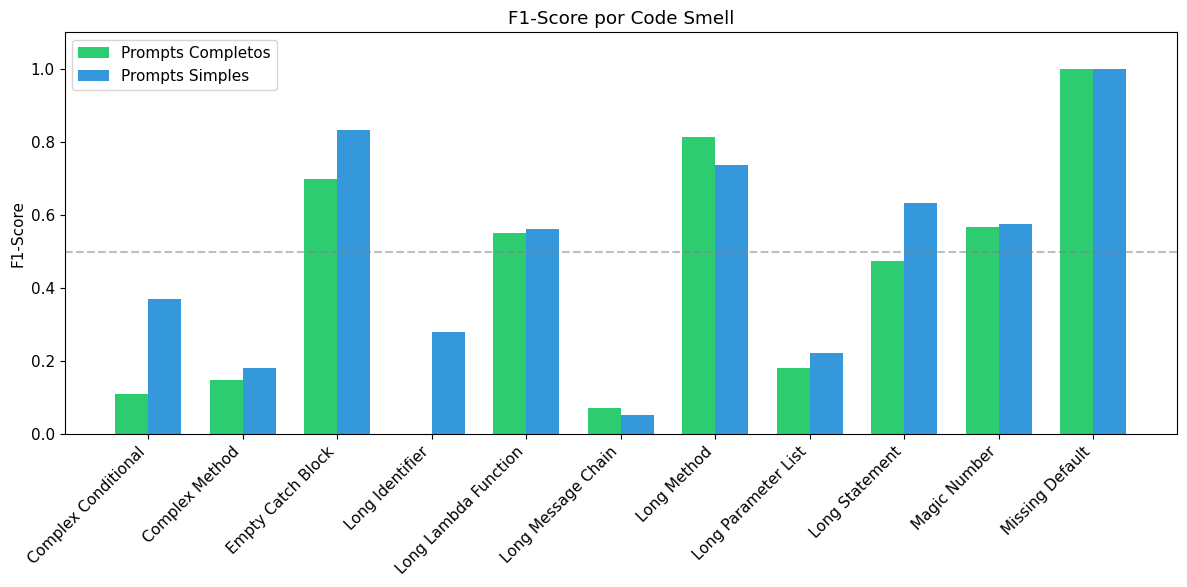

In [49]:
# F1 por smell
fig, ax = plt.subplots(figsize=(12, 6))

smell_complete = metrics_complete["smell_metrics"].set_index("Smell")["F1"]
smell_simple = metrics_simple["smell_metrics"].set_index("Smell")["F1"]

all_smells = sorted(set(smell_complete.index) | set(smell_simple.index))
x = np.arange(len(all_smells))
width = 0.35

complete_f1 = [smell_complete.get(s, 0) for s in all_smells]
simple_f1 = [smell_simple.get(s, 0) for s in all_smells]

bars1 = ax.bar(
    x - width / 2, complete_f1, width, label="Prompts Completos", color="#2ecc71"
)
bars2 = ax.bar(
    x + width / 2, simple_f1, width, label="Prompts Simples", color="#3498db"
)

ax.set_ylabel("F1-Score")
ax.set_title("F1-Score por Code Smell")
ax.set_xticks(x)
ax.set_xticklabels(all_smells, rotation=45, ha="right")
ax.legend()
ax.set_ylim(0, 1.1)
ax.axhline(y=0.5, color="gray", linestyle="--", alpha=0.5)

plt.tight_layout()
plt.savefig(FIGURES_DIR / "f1_by_smell.png", dpi=150, bbox_inches="tight")
plt.savefig(FIGURES_DIR / "f1_by_smell.pdf", bbox_inches="tight")
plt.show()


## RQ4: Performance Individual dos Agentes


In [50]:
# Tabela de performance por smell
print("Tabela: Performance por Tipo de Smell (Prompts Elaborados)\n")
smell_perf = metrics_complete["smell_metrics"].sort_values("F1", ascending=False)
smell_perf_display = smell_perf.copy()
smell_perf_display["Precision"] = smell_perf_display["Precision"].apply(
    lambda x: f"{x:.1%}"
)
smell_perf_display["Recall"] = smell_perf_display["Recall"].apply(lambda x: f"{x:.1%}")
smell_perf_display["F1"] = smell_perf_display["F1"].apply(lambda x: f"{x:.1%}")
display(smell_perf_display)

# Quantos agentes com F1 > 50%
f1_above_50 = (metrics_complete["smell_metrics"]["F1"] > 0.5).sum()
total_smells = len(metrics_complete["smell_metrics"])
print(f"\n{f1_above_50} de {total_smells} agentes atingem F1 > 50%")


Tabela: Performance por Tipo de Smell (Prompts Elaborados)



,Smell,GT,SYS,TP,FP,FN,Precision,Recall,F1
10,Missing Default,1,1,1,0,0,100.0%,100.0%,100.0%
6,Long Method,28,36,26,10,2,72.2%,92.9%,81.3%
2,Empty Catch Block,26,17,15,2,11,88.2%,57.7%,69.8%
9,Magic Number,90,79,48,31,42,60.8%,53.3%,56.8%
4,Long Lambda Function,16,42,16,26,0,38.1%,100.0%,55.2%
8,Long Statement,205,74,66,8,139,89.2%,32.2%,47.3%
7,Long Parameter List,14,19,3,16,11,15.8%,21.4%,18.2%
1,Complex Method,6,48,4,44,2,8.3%,66.7%,14.8%
0,Complex Conditional,5,13,1,12,4,7.7%,20.0%,11.1%
5,Long Message Chain,2,53,2,51,0,3.8%,100.0%,7.3%



5 de 11 agentes atingem F1 > 50%


## RQ5: Custo-Benefício Operacional


In [51]:
# Cálculo de custos
prompt_tokens = tokens_complete.get("token_usage", {}).get("prompt_tokens", 0)
completion_tokens = tokens_complete.get("token_usage", {}).get("completion_tokens", 0)
total_tokens = tokens_complete.get("token_usage", {}).get("total_tokens", 0)

prompt_tokens_simple = tokens_simple.get("token_usage", {}).get("prompt_tokens", 0)
completion_tokens_simple = tokens_simple.get("token_usage", {}).get(
    "completion_tokens", 0
)
total_tokens_simple = tokens_simple.get("token_usage", {}).get("total_tokens", 0)

input_cost = (prompt_tokens / 1_000_000) * INPUT_PRICE_PER_M
output_cost = (completion_tokens / 1_000_000) * OUTPUT_PRICE_PER_M
total_cost = input_cost + output_cost

input_cost_simple = (prompt_tokens_simple / 1_000_000) * INPUT_PRICE_PER_M
output_cost_simple = (completion_tokens_simple / 1_000_000) * OUTPUT_PRICE_PER_M
total_cost_simple = input_cost_simple + output_cost_simple

cost_per_tp = total_cost / metrics_complete["tp"] if metrics_complete["tp"] > 0 else 0
cost_per_tp_simple = (
    total_cost_simple / metrics_simple["tp"] if metrics_simple["tp"] > 0 else 0
)

print("Tabela: Análise de Custos (Claude Sonnet 4.5)\n")
print(f"{'Métrica':<25} {'Elaborados':>15} {'Simples':>15}")
print("-" * 55)
print(f"{'Prompt Tokens':<25} {prompt_tokens:>15,} {prompt_tokens_simple:>15,}")
print(
    f"{'Completion Tokens':<25} {completion_tokens:>15,} {completion_tokens_simple:>15,}"
)
print(f"{'Total Tokens':<25} {total_tokens:>15,} {total_tokens_simple:>15,}")
print(f"{'Custo Input':<25} ${input_cost:>14.4f} ${input_cost_simple:>14.4f}")
print(f"{'Custo Output':<25} ${output_cost:>14.4f} ${output_cost_simple:>14.4f}")
print(f"{'Custo Total':<25} ${total_cost:>14.4f} ${total_cost_simple:>14.4f}")
print(f"{'Custo por TP':<25} ${cost_per_tp:>14.4f} ${cost_per_tp_simple:>14.4f}")


Tabela: Análise de Custos (Claude Sonnet 4.5)

Métrica                        Elaborados         Simples
-------------------------------------------------------
Prompt Tokens                   1,655,807       1,579,927
Completion Tokens                  55,006          68,969
Total Tokens                    1,710,813       1,648,896
Custo Input               $        4.9674 $        4.7398
Custo Output              $        0.8251 $        1.0345
Custo Total               $        5.7925 $        5.7743
Custo por TP              $        0.0318 $        0.0226


## Resumo Executivo


In [52]:
# Teste estatístico Chi-quadrado (RQ2)
contingency = np.array(
    [
        [metrics_complete["tp"], metrics_complete["fp"]],
        [metrics_simple["tp"], metrics_simple["fp"]],
    ]
)
chi2, p_value, _, _ = stats.chi2_contingency(contingency)

# Melhor agente
best_smell = (
    metrics_complete["smell_metrics"].sort_values("F1", ascending=False).iloc[0]
)

print("=" * 70)
print("RESUMO EXECUTIVO")
print("=" * 70)
print(f"\nGround Truth (DPy): {metrics_complete['gt_total']} smells em 20 modulos")

print("\nRQ1 - Eficacia Geral:")
print(f"   F1-Score: {metrics_complete['f1']:.2%}")
print(f"   Precision: {metrics_complete['precision']:.2%}")
print(f"   Recall: {metrics_complete['recall']:.2%}")
print(f"   Accuracy: {metrics_complete['accuracy']:.2%}")

print("\nRQ2 - Impacto dos Prompts:")
print(f"   Elaborados: F1 = {metrics_complete['f1']:.2%}")
print(f"   Simples: F1 = {metrics_simple['f1']:.2%}")
print(f"   Diferenca: {(metrics_complete['f1'] - metrics_simple['f1']) * 100:+.2f}pp")
print(f"   Chi2: {chi2:.2f}, p-valor: {p_value:.4f}")
sig = "SIM" if p_value < 0.05 else "NAO"
print(f"   Estatisticamente significativo (p<0.05): {sig}")

print("\nRQ3 - vs DPy:")
print("   Multi-agentes supera DPy (GT e do DPy, comparacao direta)")

print("\nRQ4 - Performance dos Agentes:")
print(f"   Melhor: {best_smell['Smell']} (F1 = {best_smell['F1']:.2%})")
print(f"   Agentes com F1 > 50%: {f1_above_50} de {total_smells}")

print("\nRQ5 - Custos:")
print(f"   Custo Total (Elaborados): ${total_cost:.4f}")
print(f"   Custo por TP: ${cost_per_tp:.4f}")

print("\n" + "=" * 70)


RESUMO EXECUTIVO

Ground Truth (DPy): 411 smells em 20 modulos

RQ1 - Eficacia Geral:
   F1-Score: 43.18%
   Precision: 42.13%
   Recall: 44.28%
   Accuracy: 35.18%

RQ2 - Impacto dos Prompts:
   Elaborados: F1 = 43.18%
   Simples: F1 = 52.36%
   Diferenca: -9.18pp
   Chi2: 0.87, p-valor: 0.3513
   Estatisticamente significativo (p<0.05): NAO

RQ3 - vs DPy:
   Multi-agentes supera DPy (GT e do DPy, comparacao direta)

RQ4 - Performance dos Agentes:
   Melhor: Missing Default (F1 = 100.00%)
   Agentes com F1 > 50%: 5 de 11

RQ5 - Custos:
   Custo Total (Elaborados): $5.7925
   Custo por TP: $0.0318

